In [107]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In [109]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [110]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils_copy import *
from child_utils_copy import _cxt2str, _item2str, _s
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils_copy'): from model_utils_copy import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000028
utils ... done 0:00:00.000022
child_utils ... done 0:00:00.000068
tasks ... done 0:00:00.000030
model_utils_copy ... done 0:00:00.000065
weight_analysis ... done 0:00:00.000021


In [111]:
torch.set_grad_enabled(False);

In [112]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
#cache_dir='/nas/wab/.cache/huggingface/transformers'
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [161]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['','google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']#wab
gpt_model_names = ['gpt2/cpu','gpt2-medium/cpu','gpt2-xl/cpu','EleutherAI/gpt-j-6B/cpu',]

for model_name in gpt_model_names[1:2]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 0
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 7; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer#, device

gpt2-medium/cpu ... done 0:00:33.093611


In [160]:
models.keys()

dict_keys(['gpt2/cpu'])

In [162]:
model_name = gpt_model_names[1]
# model_name = engines[-1]
model, tokenizer = models[model_name]

In [163]:
blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim

# we = model.transformer.wte.weight.data
# wu = model.lm_head.weight.data

# es = [we]
# for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
# model.es = es
# weBTAs = [es[i].T @ es[i] for i in range(2)]
# model.weBTAs = weBTAs

In [164]:
device = torch.device('cuda:2')
_ = clone_model_to(model, device)

cloning GPT2Block0.ln_1 to cuda:2 ... done 0:00:00.016454
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.003004
cloning GPT2Block1.ln_1 to cuda:2 ... done 0:00:00.000772
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002742
cloning GPT2Block2.ln_1 to cuda:2 ... done 0:00:00.001378
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.005332
cloning GPT2Block3.ln_1 to cuda:2 ... done 0:00:00.001060
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.004018
cloning GPT2Block4.ln_1 to cuda:2 ... done 0:00:00.000327
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002065
cloning GPT2Block5.ln_1 to cuda:2 ... done 0:00:00.000590
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002045
cloning GPT2Block6.ln_1 to cuda:2 ... done 0:00:00.000677
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002071
cloning GPT2Block7.ln_1 to cuda:2 ... done 0:00:00.000670
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002047
cloning GPT2Bloc

In [117]:
sys.path.insert(0, '/nas/xd/projects/transformers/notebooks/lzt/Easy-Transformer/easy_transformer')
from ioi_dataset import (
    IOIDataset,
)
N = 50
tokenizer.pad_token = tokenizer.eos_token
ioi_dataset = IOIDataset(
    prompt_type="mixed",
    N=N,
    tokenizer=tokenizer,
    prepend_bos=False,
) 

/nas/xd/projects/transformers/notebooks/lzt/Easy-Transformer/easy_transformer/ioi_dataset.py:770: UserWarning: Some groups have less than 5 prompts, they have lengths [1, 2, 2, 3, 3, 2, 4, 1, 1]
  f"Some groups have less than 5 prompts, they have lengths {small_groups}"


In [166]:
r1 = None
result = {}

After Christine and Joseph went to the restaurant, Christine gave a bone to Joseph

In generate_and_predict_batch: predict ... done 0:00:01.104074


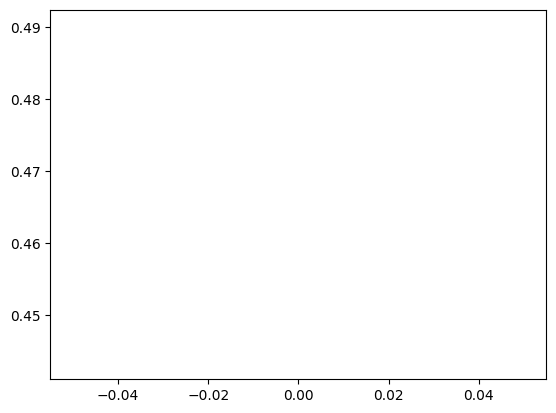

In [167]:
r1, all_examples = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=10,ioi_dataset = ioi_dataset,
                                        trim=False, result=r1, verbose=False)

*ĠJoseph 0.355 {'ĠJoseph': 0.355, 'Ġthe': 0.138, 'Ġher': 0.076} 	 After Christine and Joseph went to the restaurant, Christine gave a bone to Joseph *ĠJoseph:-79.895 ĠChristine:-84.334
1.0356634855270386 1.0


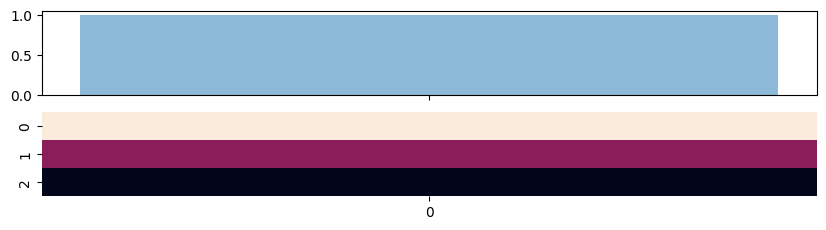

*ĠNathan 0.637 {'ĠNathan': 0.637, 'Ġhim': 0.101, 'Ġme': 0.083} 	 Then, Nathan and Emily had a long argument, and afterwards Emily said to Nathan *ĠNathan:-38.228 ĠEmily:-43.141
0.4516431391239166 1.0


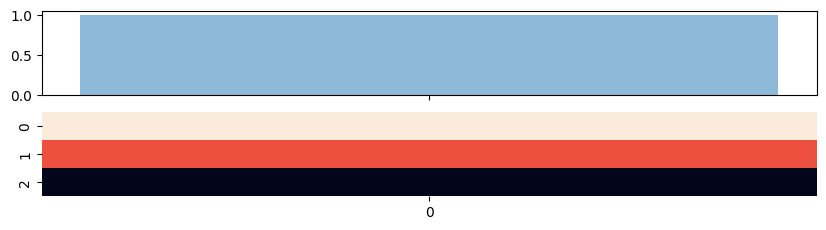

*ĠKyle 0.412 {'ĠKyle': 0.412, 'Ġthe': 0.155, 'Ġa': 0.054} 	 Then, Joseph and Kyle went to the store. Joseph gave a snack to Kyle *ĠKyle:-72.961 ĠJoseph:-75.827
0.8862001299858093 1.0


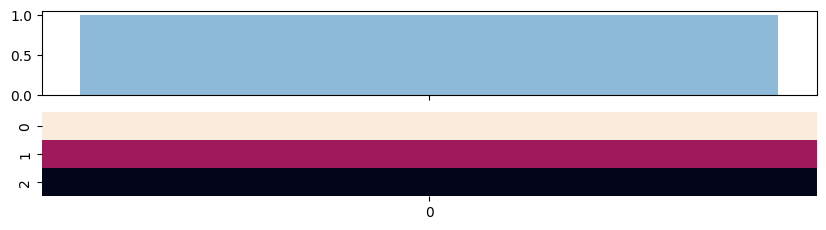

*ĠDaniel 0.284 {'ĠDaniel': 0.284, 'Ġthe': 0.159, 'Ġa': 0.102} 	 Then, Daniel and Rachel were working at the store. Rachel decided to give a snack to Daniel *ĠDaniel:-82.596 ĠRachel:-85.594
1.2581300735473633 1.0


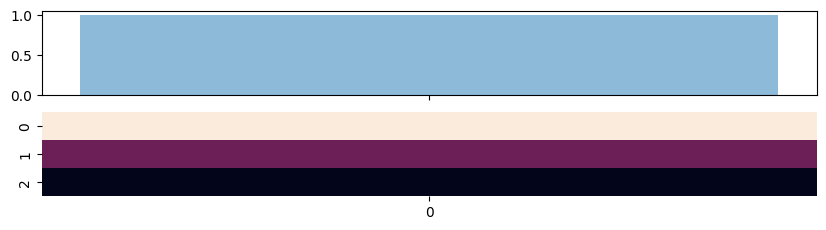

*ĠDavid 0.444 {'ĠDavid': 0.444, 'Ġhis': 0.068, 'Ġthe': 0.057} 	 Then, Charles and David had a lot of fun at the store. Charles gave a necklace to David *ĠDavid:-71.268 ĠCharles:-74.813
0.8123545050621033 1.0


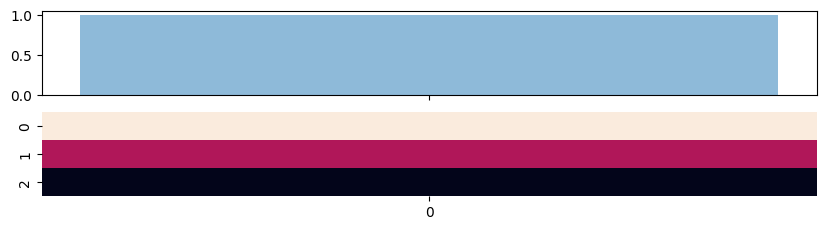

*ĠSarah 0.552 {'ĠSarah': 0.552, 'ĠRachel': 0.061, 'Ġa': 0.038} 	 Then, Rachel and Sarah had a lot of fun at the store. Rachel gave a necklace to Sarah *ĠSarah:-74.160 ĠRachel:-76.362
0.5946812033653259 1.0


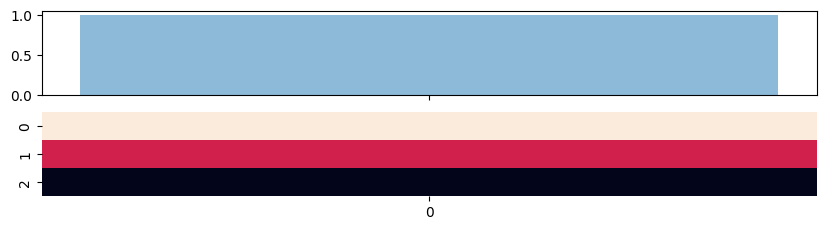

*ĠMelissa 0.289 {'ĠMelissa': 0.289, 'Ġhis': 0.156, 'Ġher': 0.125} 	 When Paul and Melissa got a basketball at the garden, Paul decided to give it to Melissa *ĠMelissa:-43.444 ĠPaul:-47.112
1.2400552034378052 1.0


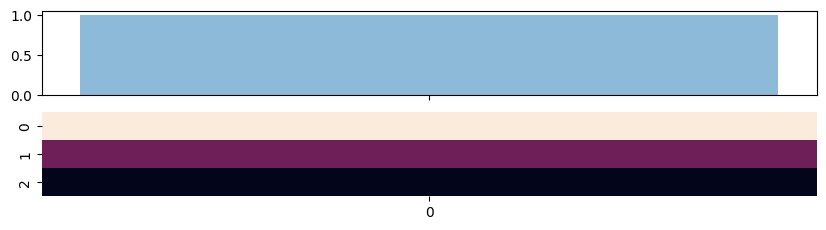

*ĠNicole 0.696 {'ĠNicole': 0.696, 'Ġme': 0.123, 'Ġher': 0.06} 	 Then, Courtney and Nicole had a long argument, and afterwards Courtney said to Nicole *ĠNicole:-55.245 ĠCourtney:-61.214
0.36293551325798035 1.0


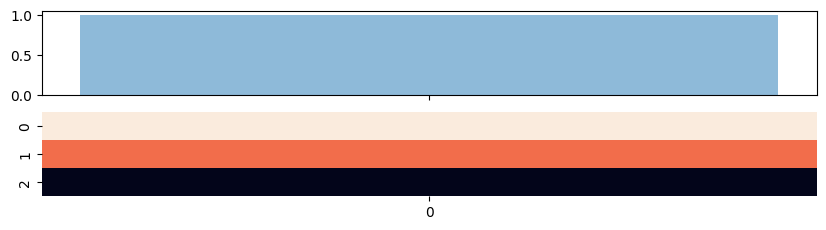

*ĠAmanda 0.372 {'ĠAmanda': 0.372, 'Ġthe': 0.105, 'Ġa': 0.066} 	 Then, Amanda and Allison had a lot of fun at the restaurant. Allison gave a snack to Amanda *ĠAmanda:-76.666 ĠAllison:-79.665
0.9887467622756958 1.0


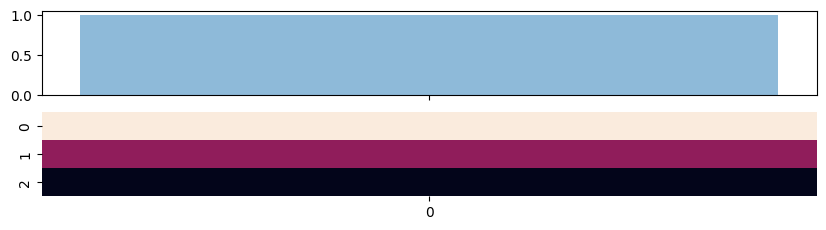

*ĠJose 0.627 {'ĠJose': 0.627, 'ĠJeffrey': 0.05, 'Ġthe': 0.043} 	 After Jose and Jeffrey went to the hospital, Jeffrey gave a drink to Jose *ĠJose:-95.241 ĠJeffrey:-97.760
0.46733585000038147 1.0


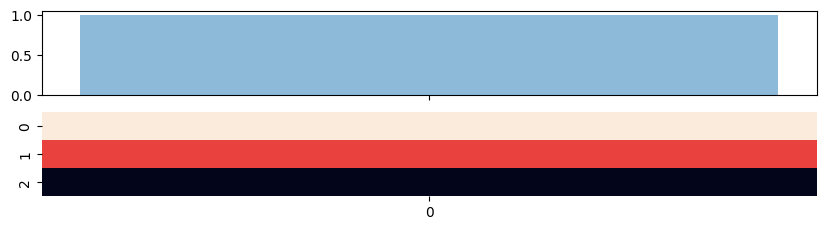

(0.809774586558342, 1.0)

In [168]:
show_predictions_by_data_tuples(model, tokenizer, r1.data_tuples, k_shot=0)

In [169]:
if True or r1.root is None: r1.root = add_node(None, layer=L, label_type='labels')
r1.root = attribute_tree_on(r1.data_tuples, model, r1.root, 1, topk=10, k_shot=0, mix=True, device=device, verbose=True)

attribute_tree ... In attribute_tree: attribute_step , topk=10 ... done 0:00:00.202820
In attribute_tree: attribute_step stage2  ... done 0:00:00.052522
In _add_node: add @1 20-7 67 B->A0 95/58 attn/ans0s
In _add_node: add @2 15-14 63 B->A0 97/59 attn/ans0s
In _add_node: add @4 16-15 60 B->A0 99/43 attn/ans0s
In _add_node: add @5 20-0 48 B->A0 96/37 attn/ans0s
In _add_node: add @7 18-5 42 B->A0 99/53 attn/ans0s
In _add_node: add @8 19-15 30 B->A0 84/37 attn/ans0s
In _add_node: add @0 19-1 100 B->s2 82/44 attn/example
In _add_node: add @3 21-7 61 B->s2+ 48/21 attn/example
In _add_node: add @6 12-3 43 B->s2 88/56 attn/example
In _add_node: add @407 22-14 -86 B->A0/63/0 attn/ans0s
In _add_node: add @397 18-9 -6 B->A0/58/0 attn/ans0s
In _add_node: add @[1,2,4,5,7,8,9] 20-7,15-14,16-15,20-0,18-5,19-15,20-6 27 B->A0 64
In _add_node: add @[0,3,6] 19-1,21-7,12-3 unk 0
In _add_node: add @[1,2,4,5,7,8]  B->A0 attn/ans0s
In _add_node: add 18-9,22-14 B->A0 attn/ans0s
In attribute_tree: attribute_s

In [170]:
print_tree(r1.root)

 ┌@[1,2,4,5,7,8,9] 20-7,15-14,16-15,20-0,18-5,19-15,20-6 27 B->A0 64
 ├@[0,3,6] 19-1,21-7,12-3 unk 0
 ├@1 20-7 67 B->A0 95/58 attn/ans0s
 ├@2 15-14 63 B->A0 97/59 attn/ans0s
 ├@4 16-15 60 B->A0 99/43 attn/ans0s
 ├@5 20-0 48 B->A0 96/37 attn/ans0s
 ├@7 18-5 42 B->A0 99/53 attn/ans0s
 ├@8 19-15 30 B->A0 84/37 attn/ans0s
 ├@397 18-9 -6 B->A0/58/0 attn/ans0s
 ├@407 22-14 -86 B->A0/63/0 attn/ans0s
 ├@0 19-1 100 B->s2 82/44 attn/example
 ├@3 21-7 61 B->s2+ 48/21 attn/example
 ├@6 12-3 43 B->s2 88/56 attn/example
 ┤
 │                                ┌@[0,2,3,6,7] 12-3,13-4 22,13-13 20,14-5 9,14-15 9 B->s2 41
 │                                ├@[1,4,5] 15-14 23,16-15 13,17-4 12 B->A0 16
 │                                ├@0 12-3 100 B->s2 91/56
 ├@[1,2,4,5,7,8]  B->A0 attn/ans0s┤
 │                                │          ┌@[1,2,4] 7-2 72,9-3 43,6-15 33 s2->s1+ 35
 │                                │          ├@[0] 0-16 100 s2->s2 20
 │                                │          ├@[3] 6-4 38 s

In [ ]:
node = r1.root.children[-1]
plot_attn_attrs(r1.data_tuples[:1], model, tokenizer, node, topi=[0], attn_patterns=['B->S'], k_shot=0)